In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [2]:
import pandas as pd
csv_path = '/root/notebooks/0858611-2/tooth_xray/model/700_700/image_generate_all_rotate/output.csv'
tooth_dataframe = pd.read_csv (csv_path)
tooth_dataframe = tooth_dataframe.sort_values(by=['Image_path'][-35:])
print (tooth_dataframe.head())

                                              Image_path  label
1492   /root/notebooks/0858611-2/tooth_xray/model/700...      1
10198  /root/notebooks/0858611-2/tooth_xray/model/700...      1
7759   /root/notebooks/0858611-2/tooth_xray/model/700...      1
15     /root/notebooks/0858611-2/tooth_xray/model/700...      1
4067   /root/notebooks/0858611-2/tooth_xray/model/700...      1


In [3]:
img_path_list = tooth_dataframe.Image_path
img_label_list = tooth_dataframe.label

In [4]:
normal_dataframe = tooth_dataframe[tooth_dataframe.label == 0]
medium_dataframe = tooth_dataframe[tooth_dataframe.label == 1]
serious_dataframe = tooth_dataframe[tooth_dataframe.label == 2]
print(len(normal_dataframe))
print(len(medium_dataframe))
print(len(serious_dataframe))
 

6867
3949
1933


In [5]:
import numpy as np
a = np.array(serious_dataframe)
print(a.shape)

(1933, 2)


In [6]:
#img to array and resize 
import cv2
import numpy as np
import matplotlib.pyplot as plt
imgsize = (256,256)

def imgpath_list_to_array_list(imgpath_list,imgsize=(256,256)):
    array_list = []
    for img_path in imgpath_list:
        img = cv2.imread(img_path,0)
        img = cv2.resize(img,imgsize)
        #img = img[:,:,0]
        #img = (img-127.5)/127.5
        array_list.append(img.reshape(256,256,1))
    return np.array(array_list)

# def label_list_to_num(train_label):
#     label_array = []
#     for symptom in train_label:
#         if symptom == 'normal':
#             label_array.append(0)
#         if symptom == 'medium':
#             label_array.append(1)
#         if symptom == 'serious':
#             label_array.append(2)
#     return np.array(label_array)

train_data_array = imgpath_list_to_array_list(tooth_dataframe.Image_path)
train_label_array = np.array(tooth_dataframe.label)

normal_data_array = imgpath_list_to_array_list(normal_dataframe.Image_path)
normal_label_array = np.array(normal_dataframe.label)
medium_data_array = imgpath_list_to_array_list(medium_dataframe.Image_path)
medium_label_array= np.array(medium_dataframe.label)
serious_data_array = imgpath_list_to_array_list(serious_dataframe.Image_path)
serious_label_array = np.array(serious_dataframe.label)


print(train_data_array.shape)
print(train_label_array.shape)


(12749, 256, 256, 1)
(12749,)


In [7]:
print(len(train_label_array))

12749


In [9]:
from tensorflow.keras import Model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input,Dropout


def my_convolution_model(input_shape, classes):
    inputs=Input(input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(classes)(x)
    model = Model(inputs, x)
    model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])
    return model

input_shape= (256,256,1)
classes    = 3
batch_size = 128
epochs     = 30

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with mirrored_strategy.scope():
    model_convolution = my_convolution_model(input_shape, classes)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [10]:
model_convolution.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0     

In [11]:
data_to_train_rate = 0.9
data_to_validation_rate = 0.07
data_to_test_rate =0.03
train_unms = int(len(train_label_array)*data_to_train_rate)
validation_nums = int(len(train_label_array)*data_to_validation_rate)
print('Have {} data, {} for training , {} for validation, {} for testing'
      .format(len(train_label_array),train_unms,validation_nums,len(train_label_array)-train_unms-validation_nums))

Have 12749 data, 11474 for training , 892 for validation, 383 for testing


In [12]:
history = model_convolution.fit(train_data_array[:train_unms], train_label_array[:train_unms], epochs=epochs, 
                     validation_data=(train_data_array[train_unms:train_unms+validation_nums], train_label_array[train_unms:train_unms+validation_nums]),shuffle=True,batch_size = batch_size)

Train on 11474 samples, validate on 892 samples
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then b

In [13]:
modelpredict = my_convolution_model(input_shape, classes)

weights = model_convolution.get_weights()
modelpredict.set_weights(weights)

892/1 - 1s - loss: 4.5601 - accuracy: 0.5045


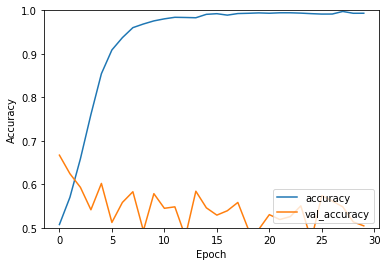

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_convolution.evaluate(train_data_array[train_unms:train_unms+validation_nums],  train_label_array[train_unms:train_unms+validation_nums], verbose=2)

In [15]:
model_convolution.evaluate(train_data_array[train_unms:train_unms+validation_nums],  train_label_array[train_unms:train_unms+validation_nums], verbose=2)

892/1 - 1s - loss: 4.5601 - accuracy: 0.5045


[4.548465223055784, 0.5044843]

In [16]:
print('following is recall rate')
print('\n# Evaluate on normal_data')
model_convolution.evaluate(normal_data_array,normal_label_array, verbose=2)

print('\n# Evaluate on medium_data')
model_convolution.evaluate(medium_data_array,medium_label_array, verbose=2)

print('\n# Evaluate on serious_data')
model_convolution.evaluate(serious_data_array,serious_label_array, verbose=2)

following is recall rate

# Evaluate on normal_data
6867/1 - 2s - loss: 0.4138 - accuracy: 0.9522

# Evaluate on medium_data
3949/1 - 2s - loss: 6.7038 - accuracy: 0.9301

# Evaluate on serious_data
1933/1 - 1s - loss: 1.2801 - accuracy: 0.9912


[0.05626199889659697, 0.9912054]

In [17]:
#prediction 

In [18]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def recall_accuracy_rate(test_data_array,test_label_array,model):
    model_predict =[]
    for img in test_data_array:
        reshape = img.reshape(1,256,256,1)
        image = tf.cast(reshape, tf.float32)
        model_predict.append(np.argmax(model.predict(image)))
        
    matrix = confusion_matrix(test_label_array, model_predict)
    matrix_split = np.split(matrix,3,axis=1)
    print('column:* is prediction result')
    print('row*: is real class')
    dict = {
            "class:0":matrix_split[0].reshape(3),
            "class:1":matrix_split[1].reshape(3),
            "class:2":matrix_split[2].reshape(3)
           }
    
    predict_table = pd.DataFrame(dict)
    return predict_table,matrix

In [19]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

In [20]:
#validation data
predict_table,matrix = recall_accuracy_rate(train_data_array[train_unms:train_unms+validation_nums],train_label_array[train_unms:train_unms+validation_nums],modelpredict)
for i in range(len(predict_table.columns)):
    p = precision(i,matrix)
    r = recall(i,matrix) 
    print('The {} precision is {:.4f}% in {} prediction and recall is {:.4f}% in {} sample'
          .format(predict_table.columns[i],p*100,matrix[:,i].sum(),r*100,matrix[i, :].sum()))
    print()

column:* is prediction result
row*: is real class
The class:0 precision is 67.3179% in 563 prediction and recall is 62.0295% in 611 sample

The class:1 precision is 26.1062% in 226 prediction and recall is 23.0469% in 256 sample

The class:2 precision is 11.6505% in 103 prediction and recall is 48.0000% in 25 sample



In [21]:
predict_table.head()

,class:0,class:1,class:2
0,379,167,65
1,171,59,26
2,13,0,12


In [22]:
#testing data
predict_table1,matrix1 = recall_accuracy_rate(train_data_array[train_unms+validation_nums:],train_label_array[train_unms+validation_nums:],modelpredict)
for i in range(len(predict_table1.columns)):
    p = precision(i,matrix1)
    r = recall(i,matrix1) 
    print('The {} precision is {:.4f}% in {} prediction and recall is {:.4f}% in {} sample'
          .format(predict_table1.columns[i],p*100,matrix1[:,i].sum(),r*100,matrix1[i, :].sum()))
    print()

column:* is prediction result
row*: is real class
The class:0 precision is 71.9231% in 260 prediction and recall is 66.7857% in 280 sample

The class:1 precision is 16.4835% in 91 prediction and recall is 16.1290% in 93 sample

The class:2 precision is 28.1250% in 32 prediction and recall is 90.0000% in 10 sample



In [23]:
predict_table1.head()

,class:0,class:1,class:2
0,187,76,17
1,72,15,6
2,1,0,9
